In [1]:
!pip install cassandra-driver pandas


In [49]:
import os
import json
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# Path to your secure connect bundle
secure_connect_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\secure-connect-cassandradb.zip"

# Path to your token file
token_file_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\cassandradb-token.json"

# Validate file existence
if not os.path.exists(secure_connect_path):
    raise FileNotFoundError(f"Secure connect bundle not found at {secure_connect_path}")
if not os.path.exists(token_file_path):
    raise FileNotFoundError(f"Token file not found at {token_file_path}")

# Load credentials from the token file
with open(token_file_path, 'r') as token_file:
    tokens = json.load(token_file)
    client_id = tokens.get("clientId")
    client_secret = tokens.get("secret")

    if not client_id or not client_secret:
        raise ValueError("client_id or client_secret is missing in the token file.")

# Connect to Astra DB
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud={'secure_connect_bundle': secure_connect_path}, auth_provider=auth_provider)

try:
    session = cluster.connect()

    # Set your keyspace
    keyspace = "Project"
    session.set_keyspace(keyspace)

    print(f"Connected to Astra DB with keyspace '{keyspace}'!")
except Exception as e:
    print(f"Failed to connect to Cassandra DB: {e}")


Connected to Astra DB with keyspace 'Project'!


In [17]:
import pandas as pd
!pip install pyarrow


# Path to your CSV file
file_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\exchange_data.csv"

# Load the CSV file
try:
    data = pd.read_csv(file_path)

    # Show the first few rows and check the column names
    print("Sample Data:")
    print(data.head())

    # Confirm the total rows and columns
    print(f"\nNumber of Rows: {data.shape[0]}, Number of Columns: {data.shape[1]}")

except FileNotFoundError:
    print(f"File not found at the path: {file_path}")
except pd.errors.EmptyDataError:
    print("The file is empty. Please check the content.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")


Sample Data:
  acronym asset_class  id locale   mic                                name  \
0    AMEX      stocks   1     us  XASE                  NYSE American, LLC   
1     NaN      stocks   2     us  XBOS                 Nasdaq OMX BX, Inc.   
2     NSX      stocks   3     us  XCIS                 NYSE National, Inc.   
3     NaN      stocks   4     us  XADF  FINRA Alternative Display Facility   
4     NaN      stocks   5     us   NaN         Unlisted Trading Privileges   

  operating_mic participant_id      type  \
0          XNYS              A  exchange   
1          XNAS              B  exchange   
2          XNYS              C  exchange   
3          FINR              D       TRF   
4          XNAS              E       SIP   

                                                 url  count  
0         https://www.nyse.com/markets/nyse-american      1  
1  https://www.nasdaq.com/solutions/nasdaq-bx-sto...      1  
2         https://www.nyse.com/markets/nyse-national      1  
3    

In [18]:
create_table_query = """
CREATE TABLE IF NOT EXISTS bronze_exchange_data (
    unique_id UUID PRIMARY KEY,
    id INT,
    type TEXT,
    asset_class TEXT,
    locale TEXT,
    name TEXT,
    acronym TEXT,
    mic TEXT,
    operating_mic TEXT,
    participant_id TEXT,
    url TEXT,
    count INT
);
"""

# Execute the query
session.execute(create_table_query)
print("Table created successfully!")


Table created successfully!


In [15]:
import numpy as np
import pandas as pd

# Path to your CSV file
file_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\exchange_data.csv"

# Load the CSV file
try:
    data = pd.read_csv(file_path)

    # Show the first few rows and check the column names
    print("Sample Data:")
    print(data.head())

    # Confirm the total rows and columns
    print(f"\nNumber of Rows: {data.shape[0]}, Number of Columns: {data.shape[1]}")

    # Replace NaN values with an empty string
    data = data.replace({np.nan: ''})

    # Confirm there are no NaN values
    print("\nNaN values replaced. Data sample:")
    print(data.head())

except FileNotFoundError:
    print(f"File not found at the path: {file_path}")
except pd.errors.EmptyDataError:
    print("The file is empty. Please check the content.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")


Sample Data:
  acronym asset_class  id locale   mic                                name  \
0    AMEX      stocks   1     us  XASE                  NYSE American, LLC   
1     NaN      stocks   2     us  XBOS                 Nasdaq OMX BX, Inc.   
2     NSX      stocks   3     us  XCIS                 NYSE National, Inc.   
3     NaN      stocks   4     us  XADF  FINRA Alternative Display Facility   
4     NaN      stocks   5     us   NaN         Unlisted Trading Privileges   

  operating_mic participant_id      type  \
0          XNYS              A  exchange   
1          XNAS              B  exchange   
2          XNYS              C  exchange   
3          FINR              D       TRF   
4          XNAS              E       SIP   

                                                 url  count  
0         https://www.nyse.com/markets/nyse-american      1  
1  https://www.nasdaq.com/solutions/nasdaq-bx-sto...      1  
2         https://www.nyse.com/markets/nyse-national      1  
3    

In [16]:
# BRONZE TABLE

from cassandra.query import BatchStatement
import numpy as np
import uuid

# Replace NaN values
data = data.replace({np.nan: ''})

# Prepared Statement
insert_query = session.prepare("""
INSERT INTO bronze_exchange_data (unique_id, id, acronym, asset_class, locale, mic, name, operating_mic, participant_id, type, url, count)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?)
""")

# Batch Insert Configuration
batch = BatchStatement()
batch_size = 500  # Adjust the batch size as needed
counter = 0

# Batch Insertion
for _, row in data.iterrows():
    batch.add(insert_query, (
        uuid.uuid4(), int(row['id']), row['acronym'], row['asset_class'], row['locale'], row['mic'],
        row['name'], row['operating_mic'], row['participant_id'], row['type'], row['url'], row['count']
    ))

    counter += 1
    if counter % batch_size == 0:  # Execute batch after every 'batch_size' rows
        session.execute(batch)
        batch.clear()

# Insert remaining rows
if counter % batch_size != 0:
    session.execute(batch)

print(f"Bulk Insert Completed! Total Rows Inserted: {counter}")


Bulk Insert Completed! Total Rows Inserted: 102816


In [53]:
#  SILVER TABLE

from cassandra.query import BatchStatement
import numpy as np
import uuid
import pandas as pd

# Assuming 'data' is a pandas DataFrame containing your data
# Replace NaN values with empty strings in the data
data = data.replace({np.nan: ''})

# Set the correct keyspace (if not already set)
session.set_keyspace('Project')

# Create the silver_exchange_data table if it doesn't already exist
create_silver_table_query = """
CREATE TABLE IF NOT EXISTS silver_exchange_data (
    unique_id UUID PRIMARY KEY,
    id INT,
    asset_class TEXT,
    locale TEXT,
    mic TEXT,
    name TEXT,
    operating_mic TEXT,
    participant_id TEXT,
    type TEXT,
    url TEXT,
    count INT
);
"""
session.execute(create_silver_table_query)

# Check if 'acronym' column exists before trying to drop it
if 'acronym' in data.columns:
    data = data.drop(columns=['acronym'])

# Remove rows with any empty or null values across any column
data.replace('', np.nan, inplace=True)  # Ensure empty strings are treated as NaN

# Drop rows with NaN values
cleaned_data = data.dropna()  # Remove rows with any NaN values

# Prepared Statement for Silver Table Insertion
insert_silver_query = session.prepare("""
INSERT INTO silver_exchange_data (unique_id, id, asset_class, locale, mic, name, operating_mic, participant_id, type, url, count)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""")

# Batch Insert Configuration
batch = BatchStatement()
batch_size = 500  # Adjust the batch size as needed
counter = 0

# Batch Insertion: Only Insert Cleaned Rows
for _, row in cleaned_data.iterrows():
    batch.add(insert_silver_query, (
        uuid.uuid4(),  # Generate unique UUID for each record
        int(row['id']),
        row['asset_class'],
        row['locale'],
        row['mic'],
        row['name'],
        row['operating_mic'],
        row['participant_id'],
        row['type'],
        row['url'],
        row['count']
    ))

    counter += 1

    # Execute the batch after every 'batch_size' rows
    if counter % batch_size == 0:
        session.execute(batch)
        batch.clear()

# Insert remaining rows if any
if counter % batch_size != 0:
    session.execute(batch)

print(f"Bulk Insert Completed for silver table! Total Rows Inserted: {counter}")


Bulk Insert Completed for silver table! Total Rows Inserted: 76608


In [59]:
#GOLDEN TABLES

import os
import json
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra.query import BatchStatement
import uuid
import pandas as pd
import numpy as np

# Cassandra credentials and secure connect bundle path
secure_connect_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\secure-connect-cassandradb.zip"
token_file_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\cassandradb-token.json"

# Validate file existence
if not os.path.exists(secure_connect_path):
    raise FileNotFoundError(f"Secure connect bundle not found at {secure_connect_path}")
if not os.path.exists(token_file_path):
    raise FileNotFoundError(f"Token file not found at {token_file_path}")

# Load credentials from the token file
with open(token_file_path, 'r') as token_file:
    tokens = json.load(token_file)
    client_id = tokens.get("clientId")
    client_secret = tokens.get("secret")

    if not client_id or not client_secret:
        raise ValueError("client_id or client_secret is missing in the token file.")

# Connect to Astra DB
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud={'secure_connect_bundle': secure_connect_path}, auth_provider=auth_provider)
session = cluster.connect()

# Set the keyspace
session.set_keyspace('Project')

# Create Golden Tables

# 1. MIC Summary
create_mic_summary = """
CREATE TABLE IF NOT EXISTS golden_mic_summary (
    mic TEXT PRIMARY KEY,
    total_count INT
);
"""
session.execute(create_mic_summary)

# 2. Operating MIC Summary
create_operating_mic_summary = """
CREATE TABLE IF NOT EXISTS golden_operating_mic_summary (
    operating_mic TEXT PRIMARY KEY,
    total_count INT
);
"""
session.execute(create_operating_mic_summary)

# 3. Type Summary
create_type_summary = """
CREATE TABLE IF NOT EXISTS golden_type_summary (
    type TEXT PRIMARY KEY,
    total_count INT
);
"""
session.execute(create_type_summary)

# Fetch data from the silver_exchange_data table
select_query = "SELECT mic, operating_mic, type FROM silver_exchange_data;"
rows = session.execute(select_query)

# Load data into a pandas DataFrame
data = pd.DataFrame(rows)

# Handle potential missing values
data = data.replace({None: np.nan})
data.dropna(inplace=True)

# Aggregate Data for Golden Tables

# 1. MIC Summary
mic_summary = data.groupby('mic').size().reset_index(name='total_count')

# 2. Operating MIC Summary
operating_mic_summary = data.groupby('operating_mic').size().reset_index(name='total_count')

# 3. Type Summary
type_summary = data.groupby('type').size().reset_index(name='total_count')

# Function to Insert Aggregated Data into Cassandra
def insert_golden_table(table_name, df, columns):
    insert_query = f"""
    INSERT INTO {table_name} ({', '.join(columns)})
    VALUES ({', '.join(['?' for _ in columns])});
    """
    prepared = session.prepare(insert_query)
    batch = BatchStatement()
    batch_size = 500
    counter = 0

    for _, row in df.iterrows():
        batch.add(prepared, tuple(row[col] for col in columns))
        counter += 1

        if counter % batch_size == 0:
            session.execute(batch)
            batch.clear()

    if counter % batch_size != 0:
        session.execute(batch)

    print(f"Inserted {counter} rows into {table_name}")

# Insert MIC Summary
insert_golden_table(
    'golden_mic_summary',
    mic_summary,
    ['mic', 'total_count']
)

# Insert Operating MIC Summary
insert_golden_table(
    'golden_operating_mic_summary',
    operating_mic_summary,
    ['operating_mic', 'total_count']
)

# Insert Type Summary
insert_golden_table(
    'golden_type_summary',
    type_summary,
    ['type', 'total_count']
)

print("All golden tables have been successfully created and populated.")


Inserted 38 rows into golden_mic_summary
Inserted 12 rows into golden_operating_mic_summary
Inserted 3 rows into golden_type_summary
All golden tables have been successfully created and populated.


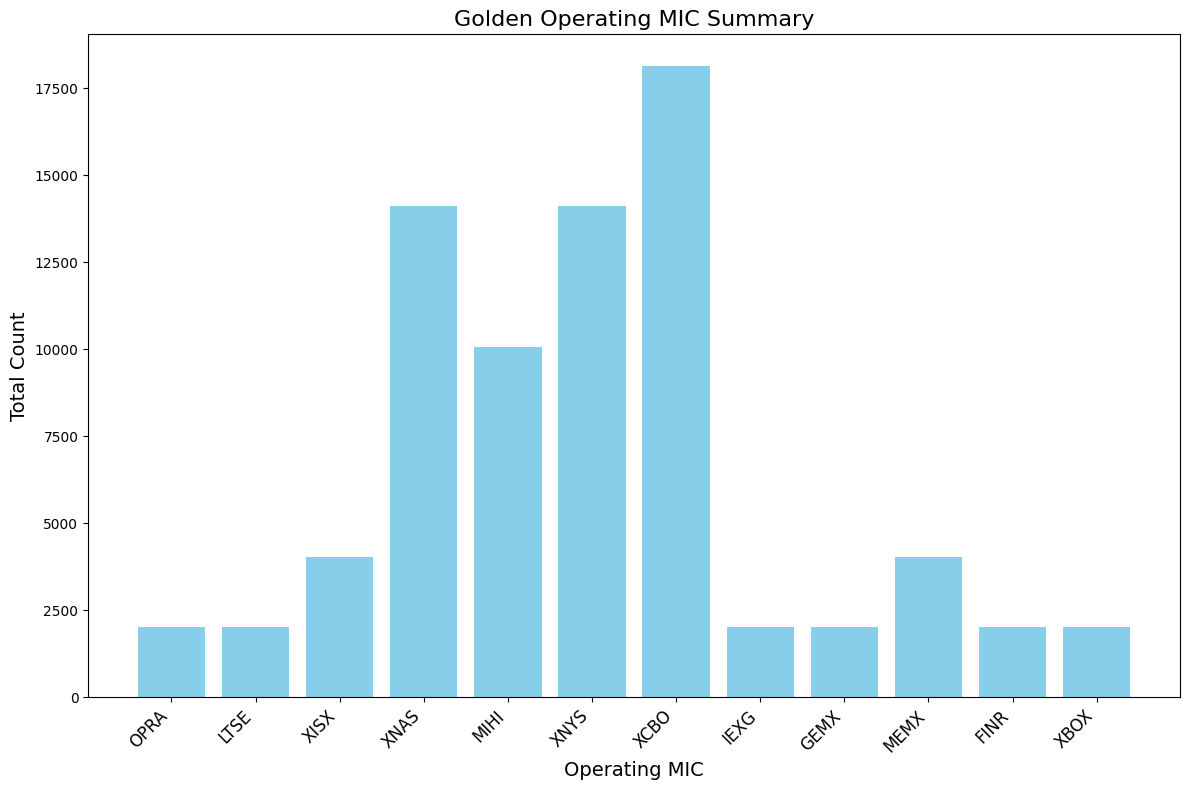

In [60]:
# BAR GRAPH -- Visualisation 1

import pandas as pd
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# Cassandra credentials and secure connect bundle path
secure_connect_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\secure-connect-cassandradb.zip"
token_file_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\cassandradb-token.json"

# Load credentials from the token file
with open(token_file_path, 'r') as token_file:
    tokens = json.load(token_file)
    client_id = tokens.get("clientId")
    client_secret = tokens.get("secret")

# Connect to Astra DB
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud={'secure_connect_bundle': secure_connect_path}, auth_provider=auth_provider)
session = cluster.connect()

# Set the keyspace
session.set_keyspace('Project')

# Query the golden_operating_mic_summary table
query = "SELECT operating_mic, total_count FROM golden_operating_mic_summary;"
rows = session.execute(query)

# Load data into a pandas DataFrame
data = pd.DataFrame(list(rows))

# Visualization
plt.figure(figsize=(12, 8))
plt.bar(data['operating_mic'], data['total_count'], color='skyblue')

# Add labels and title
plt.xlabel('Operating MIC', fontsize=14)
plt.ylabel('Total Count', fontsize=14)
plt.title('Golden Operating MIC Summary', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


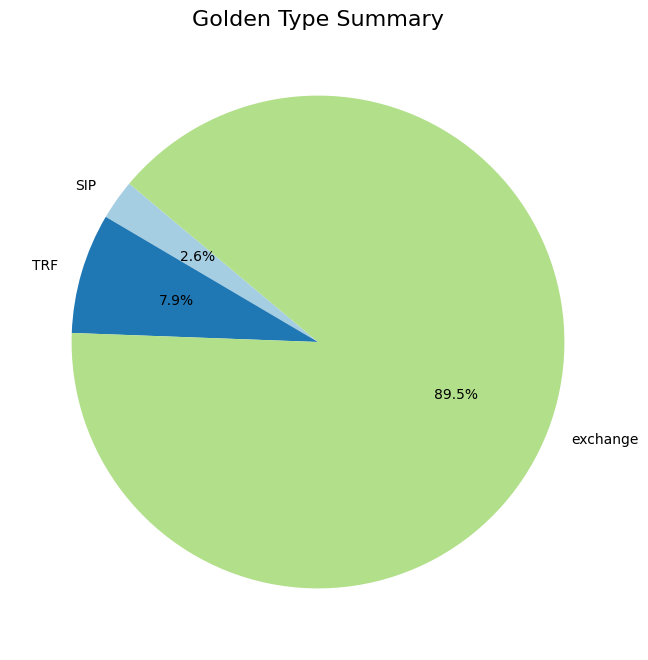

In [61]:
# PIE CHART -- Visualisation 2

import pandas as pd
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json

# Cassandra credentials and secure connect bundle path
secure_connect_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\secure-connect-cassandradb.zip"
token_file_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\cassandradb-token.json"

# Load credentials from the token file
with open(token_file_path, 'r') as token_file:
    tokens = json.load(token_file)
    client_id = tokens.get("clientId")
    client_secret = tokens.get("secret")

# Connect to Astra DB
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud={'secure_connect_bundle': secure_connect_path}, auth_provider=auth_provider)
session = cluster.connect()

# Set the keyspace
session.set_keyspace('Project')

# Query the golden_type_summary table
query = "SELECT type, total_count FROM golden_type_summary;"
rows = session.execute(query)

# Load data into a pandas DataFrame
data = pd.DataFrame(list(rows))

# Visualization
plt.figure(figsize=(8, 8))
plt.pie(
    data['total_count'], 
    labels=data['type'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)

# Add title
plt.title('Golden Type Summary', fontsize=16)

# Show the pie chart
plt.show()


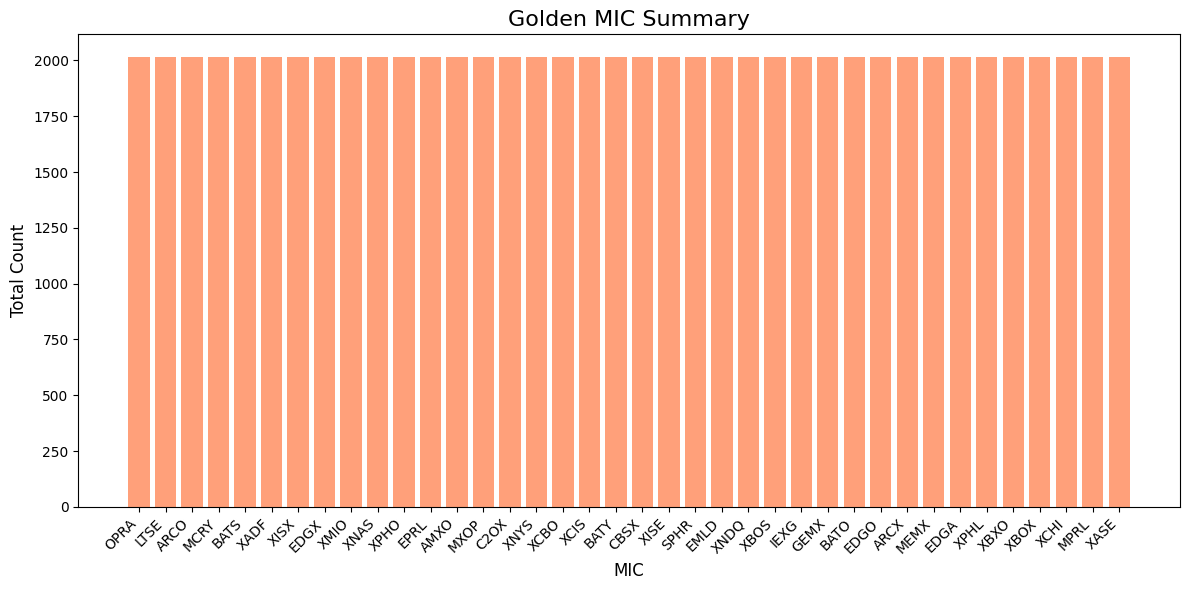

In [69]:
# BAR GRAPH -- Visualisation 3

import pandas as pd
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json

# Cassandra credentials and secure connect bundle path
secure_connect_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\secure-connect-cassandradb.zip"
token_file_path = r"D:\Doc's\Master's\Fall 2024\BigData\Project\Cassandra\cassandradb-token.json"

# Load credentials from the token file
with open(token_file_path, 'r') as token_file:
    tokens = json.load(token_file)
    client_id = tokens.get("clientId")
    client_secret = tokens.get("secret")

# Connect to Astra DB
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud={'secure_connect_bundle': secure_connect_path}, auth_provider=auth_provider)
session = cluster.connect()

# Set the keyspace
session.set_keyspace('Project')

# Query the golden_mic_summary table
query = "SELECT mic, total_count FROM golden_mic_summary;"
rows = session.execute(query)

# Load data into a pandas DataFrame
data = pd.DataFrame(list(rows))

# Visualization - Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(data['mic'], data['total_count'], color='lightsalmon')

# Add labels and title
plt.xlabel('MIC', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.title('Golden MIC Summary', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Show the chart
plt.tight_layout()
plt.show()
